In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import PIL
import IPython.display as display
import matplotlib as mpl

In [2]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

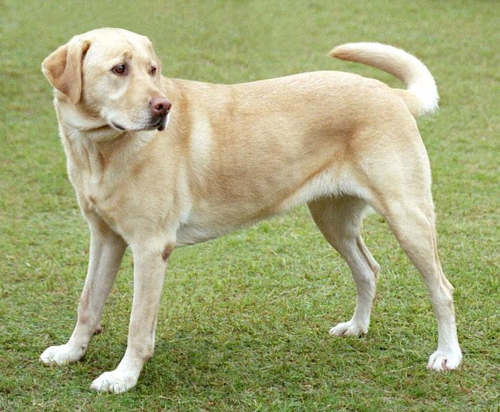

In [3]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)

## Find the fastest model

In [15]:
base_model = tf.keras.applications.MobileNetV3Small(
    input_shape=(224, 224, 3),
    include_top=False, 
    weights='imagenet'
)
with tf.device('CPU'):
    %timeit base_model(tf.random.normal((1,224,224,3)));

62.2 ms ± 404 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False, 
    weights='imagenet'
)
with tf.device('CPU'):
    %timeit base_model(tf.random.normal((1,224,224,3)));

61.6 ms ± 2.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(224, 224, 3),
    include_top=False, 
    weights='imagenet'
)
with tf.device('CPU'):
    %timeit base_model(tf.random.normal((1,224,224,3)));

24274472/24274472 [==============================] - 6s 0us/step
111 ms ± 1.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False, 
    weights='imagenet'
)
with tf.device('CPU'):
    %timeit base_model(tf.random.normal((1,224,224,3)));

16705208/16705208 [==============================] - 6s 0us/step
112 ms ± 5.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We go with the MobileNetV2.

## Model export and sanity check

In [54]:
H,W,D = (224,224,3)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(H,W,D),
    include_top=False, 
    weights='imagenet'
)

In [55]:
inp = tf.random.normal((1,H,W,D))
out = base_model(inp)
out.shape

TensorShape([1, 7, 7, 1280])

In [56]:
[l.name for l in base_model.layers]

['input_28',
 'Conv1',
 'bn_Conv1',
 'Conv1_relu',
 'expanded_conv_depthwise',
 'expanded_conv_depthwise_BN',
 'expanded_conv_depthwise_relu',
 'expanded_conv_project',
 'expanded_conv_project_BN',
 'block_1_expand',
 'block_1_expand_BN',
 'block_1_expand_relu',
 'block_1_pad',
 'block_1_depthwise',
 'block_1_depthwise_BN',
 'block_1_depthwise_relu',
 'block_1_project',
 'block_1_project_BN',
 'block_2_expand',
 'block_2_expand_BN',
 'block_2_expand_relu',
 'block_2_depthwise',
 'block_2_depthwise_BN',
 'block_2_depthwise_relu',
 'block_2_project',
 'block_2_project_BN',
 'block_2_add',
 'block_3_expand',
 'block_3_expand_BN',
 'block_3_expand_relu',
 'block_3_pad',
 'block_3_depthwise',
 'block_3_depthwise_BN',
 'block_3_depthwise_relu',
 'block_3_project',
 'block_3_project_BN',
 'block_4_expand',
 'block_4_expand_BN',
 'block_4_expand_relu',
 'block_4_depthwise',
 'block_4_depthwise_BN',
 'block_4_depthwise_relu',
 'block_4_project',
 'block_4_project_BN',
 'block_4_add',
 'block_5_

In [69]:
rescaling = tf.keras.applications.mobilenet_v2.preprocess_input

In [73]:
rescaling()

<function keras.applications.mobilenet_v2.preprocess_input(x, data_format=None)>

In [81]:
# Maximize the activations of these layers
names = ['block_2_add','block_5_add','block_7_add','block_11_add', 'block_14_add']

layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.inputs, outputs=layers)

inputs = keras.Input((H,W,D),dtype='float32')
x = inputs
# x = rescaling(inputs)
x = dream_model(x)
outputs = x

dream_model = keras.Model(inputs=inputs, outputs=outputs)

In [85]:
# tf.saved_model.save(dream_model, 'models/deep_dream/', )
@tf.function(
    input_signature=[tf.TensorSpec(shape=(H,W,D),
                                   dtype=tf.float32,name='image')]
)
def signature(image):
    image = image[tf.newaxis,...]
#     image /= 127.5
#     image -= 1.
    out = dream_model(image)
    
    return out

out = dream_model(inp)
dream_model.save('models/deep_dream/', signatures=signature)

INFO:tensorflow:Assets written to: models/deep_dream/assets


INFO:tensorflow:Assets written to: models/deep_dream/assets


In [84]:
!rm -rf ../../public/models/deep_dream/
!tensorflowjs_converter \
    models/deep_dream/ \
    ../../public/models/deep_dream/ \
    --input_format="keras_saved_model" \
    --output_format="tfjs_layers_model" \
    --strip_debug_ops=False \
    --quantize_float16="*" 

/bin/bash: /home/tornikeo/.miniconda3/envs/tfjs/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/tornikeo/.miniconda3/envs/tfjs/lib/libtinfo.so.6: no version information available (required by /bin/bash)
2022-06-19 00:57:02.947660: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 00:57:02.952466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 00:57:02.952609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 00:57:02.952942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This Tensor